# Автоэнкодеры. Вариационные автоэнкодеры

Сегодняшний семинар посвящен автоэнкодерам: моделям для кодирования объектов.



![Encoder-Decoder](https://miro.medium.com/max/1400/1*UdOybs9wOe3zW8vDAfj9VA@2x.png)

Задача автоэнкодеров - выучивать тождественное преобразование, то есть такое, что по итогу применения нейронной сети на выходе получается объект, максимально похожий на вход.

Примеры таких преобразований:

- $y = \sqrt{x^2}\cdot \frac{\|x\|}{x}$
- $y = \tanh ({\operatorname{atanh} x})$



## Цели автоэнкодеров

- сжатие данных
- изучение скрытой структуры в данных

![](https://miro.medium.com/max/1400/1*F-3zbCL_lp7EclKowfowMA@2x.png)

![1](https://miro.medium.com/max/1400/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png)

### Perceptual loss

Для лучшего воспроизведения закодированных картинок не подойдет MSE Loss (формула сверху) - на картинках не будет четких линий и будет виден артифакт в виде размытости.

К сожалению, эта проблема сохраняется при использовании моделей любых сложностей, так как артифакт связан с особенностью MSE.

Проблему можно решить, используя более хитрые функции потерь, например [VGG Perceptual loss](https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49).

Предобученная нейросеть VGG выступает в качестве экстрактора визуальных признаков, и теперь сравнивается не только похожесть полученной с помощью декодирования картинки, но и промежуточные извлеченные фичи.

<image src="https://d3i71xaburhd42.cloudfront.net/d6ae5ea0bbdafb5133f344ffc1c32987cf18a4f6/3-Figure1-1.png">

In [156]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [60]:
# Get the dataset with facial annotation
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!tar xzf tmp.tgz


--2024-08-28 14:46:43--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

tmp.tgz             100%[===================>] 103.72M  1.37MB/s    in 1m 42s  

2024-08-28 14:48:25 (1.02 MB/s) - ‘tmp.tgz’ saved [108761145/108761145]

--2024-08-28 14:48:25--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2024-08-28 14:48:26--  https://www.cs.columbia.edu/CAVE/databases/p

In [115]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
dataset = ImageFolder(
    root='lfw-deepfunneled',
    transform=Compose(
        [ToTensor(), Resize(256), Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    ))

In [119]:
train_subset, val_subset = torch.utils.data.random_split(dataset, [0.9, 0.1])

In [122]:
train_subset[5][0].min(), train_subset[5][0].max()

(tensor(-1.), tensor(0.9985))

In [2]:
"""
class AE(nn.Module):

    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()
        self.x_dim = x_dim
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, z_dim)

        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self,x):
        encoded = self.encoder(x.view(-1, self.x_dim))

        return self.decoder(encoded)
"""

'\nclass AE(nn.Module):\n\n    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):\n        super().__init__()\n        self.x_dim = x_dim\n        self.fc1 = nn.Linear(x_dim, h_dim1)\n        self.fc2 = nn.Linear(h_dim1, h_dim2)\n        self.fc3 = nn.Linear(h_dim2, z_dim)\n\n        self.fc4 = nn.Linear(z_dim, h_dim2)\n        self.fc5 = nn.Linear(h_dim2, h_dim1)\n        self.fc6 = nn.Linear(h_dim1, x_dim)\n\n    def encoder(self, x):\n        h = F.relu(self.fc1(x))\n        h = F.relu(self.fc2(h))\n        return self.fc3(h)\n\n    def decoder(self, z):\n        h = F.relu(self.fc4(z))\n        h = F.relu(self.fc5(h))\n        return torch.sigmoid(self.fc6(h))\n\n    def forward(self,x):\n        encoded = self.encoder(x.view(-1, self.x_dim))\n\n        return self.decoder(encoded)\n'

In [123]:
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class AutoEncoderCustom(nn.Module):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: list = None,
                 **kwargs) -> None:
        super().__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 128, 256, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_last = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> list[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Return the result
        return self.fc_last(result)

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent encoded vectors of size E
        onto the image space HxW.
        Args:
            z: (Tensor) [B x E].
        Returns:
            (Tensor) [B x C x H x W].
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor) -> Tensor:
        encoded = self.encode(input) # get latent vector

        return self.decode(encoded) # get the reconstruction from the latent vector

    def loss_function(self,
                      *args,
                      **kwargs) -> Tensor:
        """Computes the reconstruction loss."""
        recons = args[0]
        input = args[1]

        return F.mse_loss(recons, input)

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

In [159]:
autoencoder = AutoEncoderCustom(in_channels=3, latent_dim=512).cuda()

### Sanity check

In [160]:
random_tensor = torch.randn(1,3, 256, 256).cuda()
print("Encoder result:", autoencoder.encoder(random_tensor).flatten(start_dim=1).shape)

latent_vector = autoencoder.encode(random_tensor)
print("Decoder result:", autoencoder.decode(latent_vector).shape)
reconstructed = autoencoder(random_tensor)

if not reconstructed.shape == random_tensor.shape:
    raise ValueError('Shapes of input and output tensors must be equal!')


Encoder result: torch.Size([1, 2048])
Decoder result: torch.Size([1, 3, 256, 256])


In [161]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_subset,
    batch_size=32,
    shuffle=True,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = val_subset,
    batch_size=32,
    pin_memory=True,
    shuffle=False
)

In [162]:
for batch in train_loader:
    break

In [163]:
batch[0].shape

torch.Size([32, 3, 256, 256])

In [164]:
vgg_loss = VGGPerceptualLoss().cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [165]:
optimizer = torch.optim.Adam(autoencoder.parameters())

def train(epoch):
    autoencoder.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        input_batch = data.cuda()
        #print(data.shape)
        optimizer.zero_grad()

        recon_batch = autoencoder(input_batch)
        #print(recon_batch.shape)
        reconstruction_loss = autoencoder.loss_function(recon_batch, input_batch)
        perceptual_loss = vgg_loss(recon_batch, input_batch)
        loss = reconstruction_loss + 0.5*perceptual_loss
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f'Train epoch: {epoch},  {batch_idx}/{len(train_loader)}\tLoss: {loss.item()}')

    print(f'Epoch {epoch}\tAvg loss: {train_loss/len(train_loader)}')
    return train_loss/len(train_loader.dataset)

In [168]:
def test():
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            input_batch = data.cuda()
            optimizer.zero_grad()

            recon_batch = autoencoder(input_batch)
            reconstruction_loss = autoencoder.loss_function(recon_batch, input_batch)
            perceptual_loss = vgg_loss(recon_batch, input_batch)
            loss = reconstruction_loss + 0.5*perceptual_loss

            test_loss += loss.item()

    print(f'\tTest loss: {test_loss/len(test_loader)}')
    return test_loss/len(test_loader)

In [ ]:
N_EPOCHS = 3
train_losses = []
test_losses = []

for i in range(N_EPOCHS):
    train_losses.append(train(i))
    test_losses.append(test())

Train epoch: 0,  0/373	Loss: 2.847452402114868
Train epoch: 0,  50/373	Loss: 2.8804800510406494
Train epoch: 0,  100/373	Loss: 2.794538736343384
Train epoch: 0,  150/373	Loss: 2.731454849243164
Train epoch: 0,  200/373	Loss: 2.708711862564087
Train epoch: 0,  250/373	Loss: 2.6998722553253174
Train epoch: 0,  300/373	Loss: 2.8329591751098633
Train epoch: 0,  350/373	Loss: 2.727189779281616
Epoch 0	Avg loss: 2.8153715108099315
	Test loss: 2.771518497239976
Train epoch: 1,  0/373	Loss: 2.7572689056396484
Train epoch: 1,  50/373	Loss: 2.7561540603637695


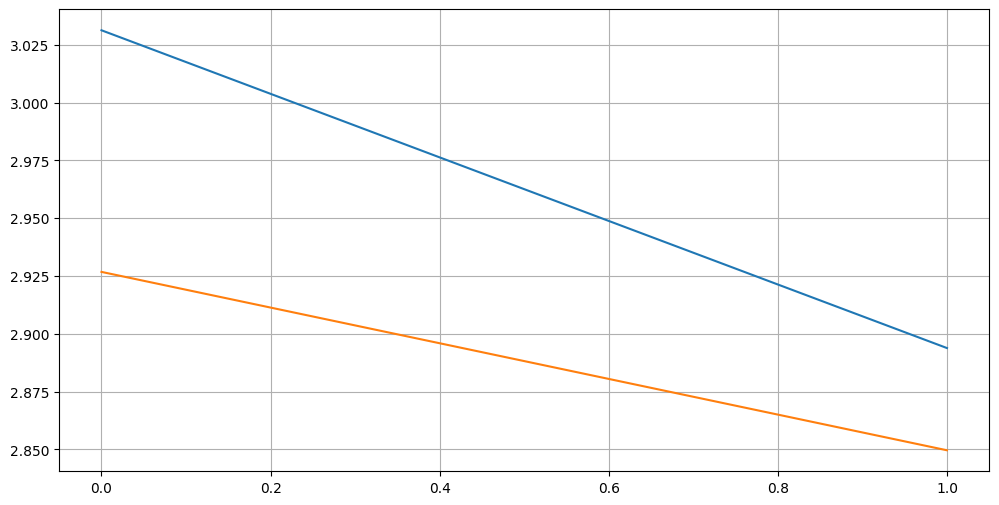

In [173]:
plt.figure(figsize=(12,6))
plt.plot(32*np.array(train_losses))
plt.plot(test_losses)
plt.grid()
plt.show()

In [174]:
for batch_idx, (data, _) in enumerate(test_loader):
    with torch.no_grad():
        input_batch = data.cuda()
        reconstructed = (autoencoder(input_batch) + 1) / 2
    break

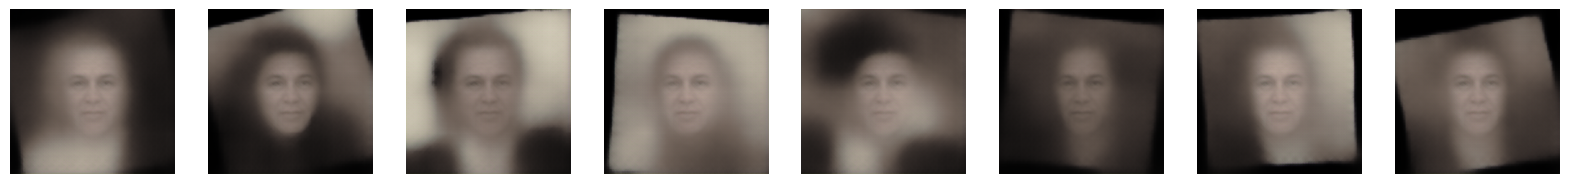

In [175]:
fig, ax = plt.subplots(1, 8, figsize=(20,20))
for i in range(1):
    for j in range(8):

        ax[j].imshow((reconstructed[i*8 + j].cpu().numpy().transpose(1, 2 ,0)* 255).astype(np.uint8))
        ax[j].axis('off')

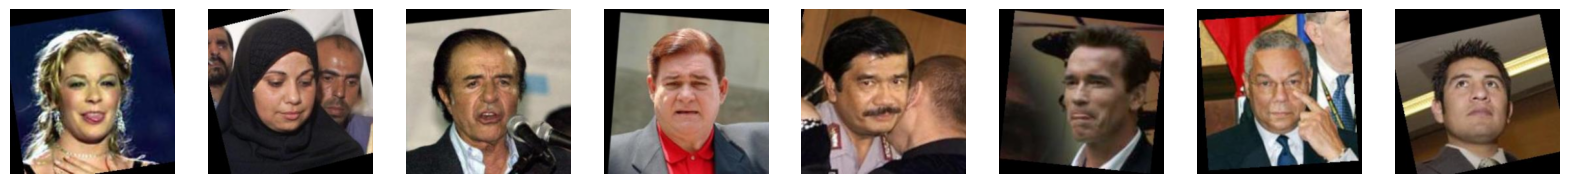

In [176]:
fig, ax = plt.subplots(1, 8, figsize=(20,20))
for i in range(1):
    for j in range(8):

        ax[j].imshow((((input_batch[i*8 + j]+1)/2).cpu().numpy().transpose(1, 2 ,0)* 255).astype(np.uint8))
        ax[j].axis('off')

In [ ]:
z = torch.randn(1)*-100000

In [ ]:
plt.imshow(ae.decoder(z.cuda()).view(28,28).detach().cpu().numpy())

## Недостатки автоэнкодеров

При обучении автоэнкодера мы просто заставляли нейросеть генерировать вектор $Z$ без каких-либо ограничений на латентное пространство. В итоге, непонятно, есть ли какая-то упорядоченная структура в этом пространстве или нет. Также непонятно, какой эффект будет наблюдаться при реконструкции в случае малых изменений координат вектора $Z$.

Для поиска структуры в данных и ее дальнейшего изучения или изменения латентное пространство должно быть структурировано, а именно:
 - малые изменения координат вектора $Z$ должны приводить к малым изменениям реконструированного изображения (принцип непрерывности),
 - случайно сгенерированный вектор из латентного пространства должен приводить к генерации осмысленной картинки (принцип полноты).

 По умолчанию эти условия выполняться не будут в случае обучения автоэнкодера :(

# Вариационные автоэнкодеры (Variational auto encoders)

![](https://miro.medium.com/max/1400/1*83S0T8IEJyudR_I5rI9now@2x.png)

Для того чтобы получить упорядоченное латентное пространство, необходимо изменить процедуру обучения и изменить функцию потерь.

Пусть теперь энкодер нейросети генерирует два вектора:

$$\mu, \sigma = F(x).$$

Затем, сгенерируем следующий случайный вектор:

$$z \sim \mathcal N(\mu, \sigma), $$ то есть теперь мы получаем некоторый случайный вектор, который в зависимости от параметров распределения будет содержать информацию о разных входных данных.

Вектор $z$ уже поступит на вход декодеру, который сгенерирует на его основе изображение.

## А как быть с градиентами?

При процедуре генерации случайного вектора мы теряем возможность использовать backward propagation для обучения: $\frac{\partial L}{\partial \mu}$ не определено, операция генерации случайных чисел не дифференцируема.

Для того чтобы разрешить эту проблему, воспользуемся следующим трюком:

$$\epsilon \sim \mathcal N (0,1),$$

$$z = \sigma \cdot \epsilon + \mu.$$

Тогда

$$\frac{dL}{d\mu} = \frac{dL}{dz}\cdot \mathbf 1$$
$$\frac{dL}{d\sigma} = \frac{dL}{dz}\cdot \epsilon.$$

Такие вычисления называются репараметризационным трюком.

## Функция потерь

Вариационный автоэнкодер также требует, чтобы параметры $\mu$ и $\sigma$ сами удовлетворяли стандартному нормальному распределению. Для этого функция потерь должна быть снабжена специальным слагаемым, которое будет контролировать отклонение этих величин от нормально распределенных.

Такое слагаемое называется дивергенция Кульбака-Лейблера (KL-divergence):

$$D_{KL}(P(x)\| Q(x)) = \sum_{x \in \mathcal X} P(x)\log \frac{P(x)}{Q(x)}.$$

Иными словами, KL-дивергенция - это мат.ожидание логарифмической разницы двух распределений, взвешенное величиной $P(x)$.


## Take-out message

Вариационный автоэнкодер смотрит на проблему следующим образом: пусть тому или иному датасету картинок можно сопоставить некое параметризуемое распределение $P(X)$ случайной величины, тогда для каждой реализации этой случайной величины найдется соответствующая картинка.

$$P(X) \rightarrow z \rightarrow D(z) \rightarrow \text{картинка}.$$

Функция потерь составлена так, что $P(X)$ должно быть максимально похоже на стандартное нормальное распределение. Такие жесткие ограничения приводят к тому, что латентное пространство становится автоматически упорядоченным (выполняется принцип полноты и непрерывности), в результате мы получаем более работоспособную архитектуру.

In [ ]:
class VAE(nn.Module):
    """Simple variational autoencoder based on fc layers."""

    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):

        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)

        self.fc31 = nn.Linear(h_dim2, z_dim) # mu
        self.fc32 = nn.Linear(h_dim2, z_dim) # sigma

        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return eps.mul(std).add_(mu) # z

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self,x):
        mu, log_var = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

def loss_function(recon_batch, x, mu, log_var):
    #BCE = F.binary_cross_entropy(recon_batch, x.view(-1, 784), reduction='sum')
    MSE = torch.mean((recon_batch - x.view(-1, 784))**2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class VanillaVAE(nn.Module):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: list = None,
                 **kwargs) -> None:
        super().__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> list[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> list[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=1)
vae.cuda()

In [ ]:
optimizer = optim.Adam(vae.parameters())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size=128)

In [ ]:
optimizer = optim.Adam(vae.parameters())


def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f'Train epoch: {epoch},  {batch_idx}/{len(data)}\tLoss: {loss.item()}')

    print(f'Epoch {epoch}\tAvg loss: {train_loss/len(train_loader.dataset)}')

def test():
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.cuda()
            optimizer.zero_grad()

            recon_batch, _ = vae.encoder(data.view(-1, 784))
            #print(recon_batch.shape)
            recon_batch = vae.decoder(recon_batch)
            loss = torch.mean((recon_batch - data.view(-1, 784))**2)
            #loss = loss_function(recon_batch, data, mu, log_var)

            test_loss += loss.item()

    print(f'\tTest loss: {test_loss/len(test_loader.dataset)}')

In [ ]:
for epoch in range(1, 30):
    train(epoch)
    test()

In [ ]:
z = torch.linspace(-0.01,0.01,10)

fig, ax = plt.subplots(2,5)

for i in range(2):
    for j in range(5):
        num = z[i*5+j].view(1,1).cuda().float()
        print(num)
        #vae.decoder(torch.tensor([0]).cuda().float())
        ax[i,j].imshow(vae.decoder(num).detach().cpu().view(28,28).numpy())

In [ ]:
vae.encoder(test_dataset[0][0].view(-1,784).cuda())

In [ ]:
plt.imshow(vae.decoder(torch.tensor([-4.2096e-07]).cuda()).detach().cpu().view(28,28).numpy())

In [ ]:
plt.imshow(test_dataset[0][0][0])